# Capstone Project

AI-Usage Disclaimer: This notebook has been written with the usage of the Github Copilot Virtualstudio Code extention.

In [1]:
# importing the required lib's
import requests
import pandas as pd
import matplotlib.pyplot as plt

# !pip install beautifulsoup4
from bs4 import BeautifulSoup
import time

# Data Aquesition

sadly the single entries are not nicely labeled that one can access them easily
in order to extract the text from the html code in the following the columns will be extracted mit direkter ansprache der zeile in der diese vorkommen, dies ist leider nur so möglich und sehr unschön da im falle eines updates sich die spaltenverteilung ändern könnte und der programmcode angepasst werden muss.

In [2]:
def extract_table_data(html_code):
    soup = BeautifulSoup(html_code, 'html.parser')
    date, time, department, category = [], [], [], []

    rows = soup.find_all('tr')[:-1]  # Exclude the last row because it includes the "weitere" button
    for row in rows:
        column = row.find_all('td')
        date.append(column[0].get_text())
        time.append(column[2].get_text())
        department.append(column[4].get_text())
        category.append(column[6].get_text())

    # transforming the data into a pandas dataframe
    df = pd.DataFrame({
    'date': date,
    'time': time,
    'department': department,
    'category': category
    })
    return df

### Sleeping Time

Before starting the webscraping task the a breef trought should be taken on the aggressiveness of the scrapingalgorithm.

On the start page of the website, usage statistics are displayed. To prevent getting blocked, it's advisable to wait a bit before scraping the next page. Based on my observations, an average of 20 to 40 requests is typical for the website.

![averageUsage of fox112](https://i.imgur.com/sJIyNIa.png "Average Usage")

To avoid overloading the server and potential blocking, I limited the number of requests to 4 per minute.


In [4]:
more_pages = True
page = 24
data = pd.DataFrame()

while more_pages == True:
    print(f"Now scraping page {page}")
    url = f"https://kiel.fox112.de/HomePageEinsaetze.php?nextea={page}"
    html = requests.get(url).text

    data = pd.concat([data, extract_table_data(html)])

    # Checking if there are more pages
    if "Es sind keine Einsätze bekannt." in html:
        more_pages = False
    else:
        page += 24

    time.sleep(15) 

Now scraping page 24
Now scraping page 48
Now scraping page 72
Now scraping page 96
Now scraping page 120
Now scraping page 144
Now scraping page 168
Now scraping page 192
Now scraping page 216
Now scraping page 240
Now scraping page 264
Now scraping page 288
Now scraping page 312
Now scraping page 336
Now scraping page 360
Now scraping page 384
Now scraping page 408
Now scraping page 432
Now scraping page 456
Now scraping page 480
Now scraping page 504
Now scraping page 528
Now scraping page 552
Now scraping page 576
Now scraping page 600
Now scraping page 624
Now scraping page 648
Now scraping page 672
Now scraping page 696
Now scraping page 720
Now scraping page 744
Now scraping page 768
Now scraping page 792
Now scraping page 816
Now scraping page 840
Now scraping page 864
Now scraping page 888
Now scraping page 912
Now scraping page 936
Now scraping page 960
Now scraping page 984
Now scraping page 1008
Now scraping page 1032
Now scraping page 1056
Now scraping page 1080
Now scrapi

# Data Preperation

In [4]:
# the concat function messes witht he dataframe
data.reset_index(drop=True, inplace=True)

In [5]:
# combine date DD.MM.YYYY and time columns into a single datetime column
data['datetime'] = pd.to_datetime(data["date"] + " " + data["time"], format='%d.%m.%Y %H:%M')

# drop the date and time columns
df = data.drop(columns=['date', 'time'])

In [6]:
# make to category data type
df['category'] = df['category'].astype('category')
df["department"] = df["department"].astype('category')

# Data Visualisation

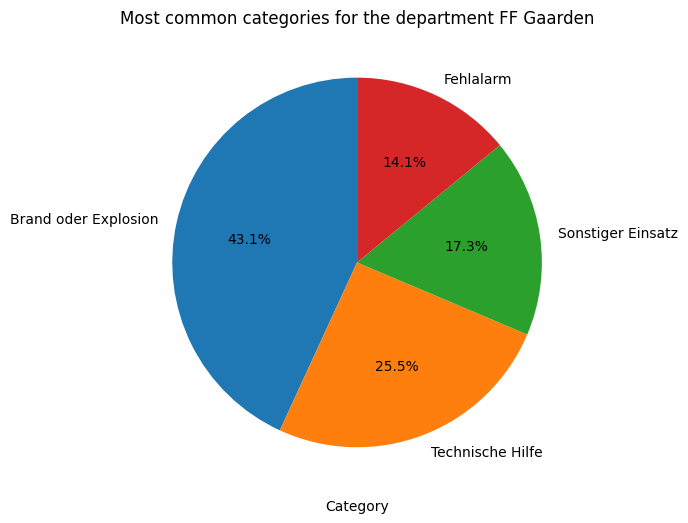

In [7]:
# Filter data for the "FF Gaarden" department
filtered_df = df[df["department"] == "FF Gaarden"]

# Get the value counts for each category
category_counts = filtered_df["category"].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Most common categories for the department FF Gaarden")
plt.xlabel("Category")
plt.show()


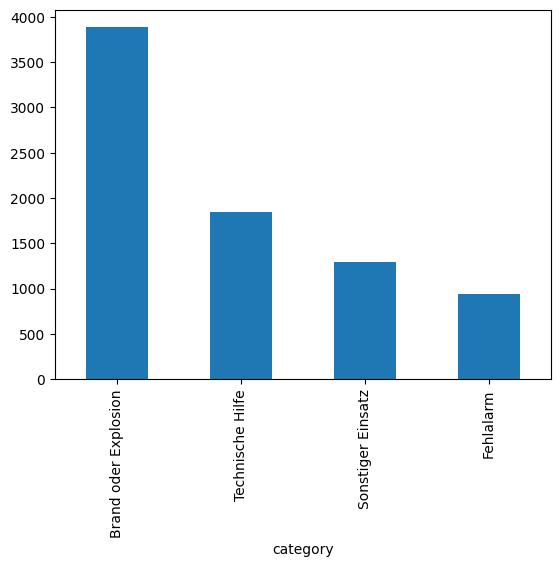

In [8]:
# plot the most common categories
ax = df["category"].value_counts().plot(kind='bar')

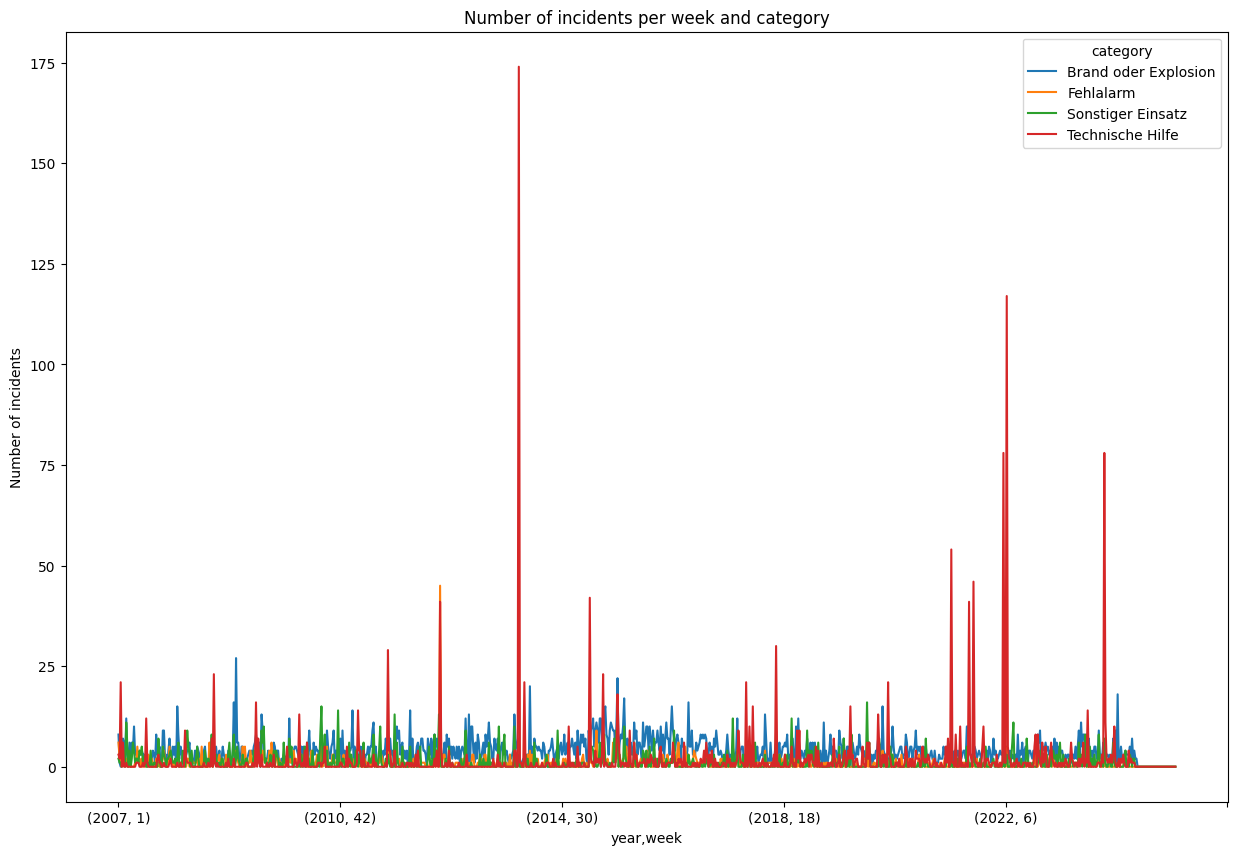

In [10]:
# plot a time series of the number of incidents per week and category as color

df["week"] = df["datetime"].dt.isocalendar().week
df["year"] = df["datetime"].dt.year

df.groupby(["year", "week", "category"], observed=False).size().unstack().plot(kind='line', figsize=(15, 10))
plt.title("Number of incidents per week and category")
plt.ylabel("Number of incidents")
plt.show()


In [14]:
# print the week with the most incidents so i can do .head(5)
df.groupby(["year", "week"]).size().sort_values(ascending=False).head(5)

year  week
2013  44      188
2022  7       127
2012  26      101
2023  42       93
2022  4        87
dtype: int64

![Text](https://i.imgur.com/g2A0PSf.png)
![Text2](https://i.imgur.com/xNuwijs.png)

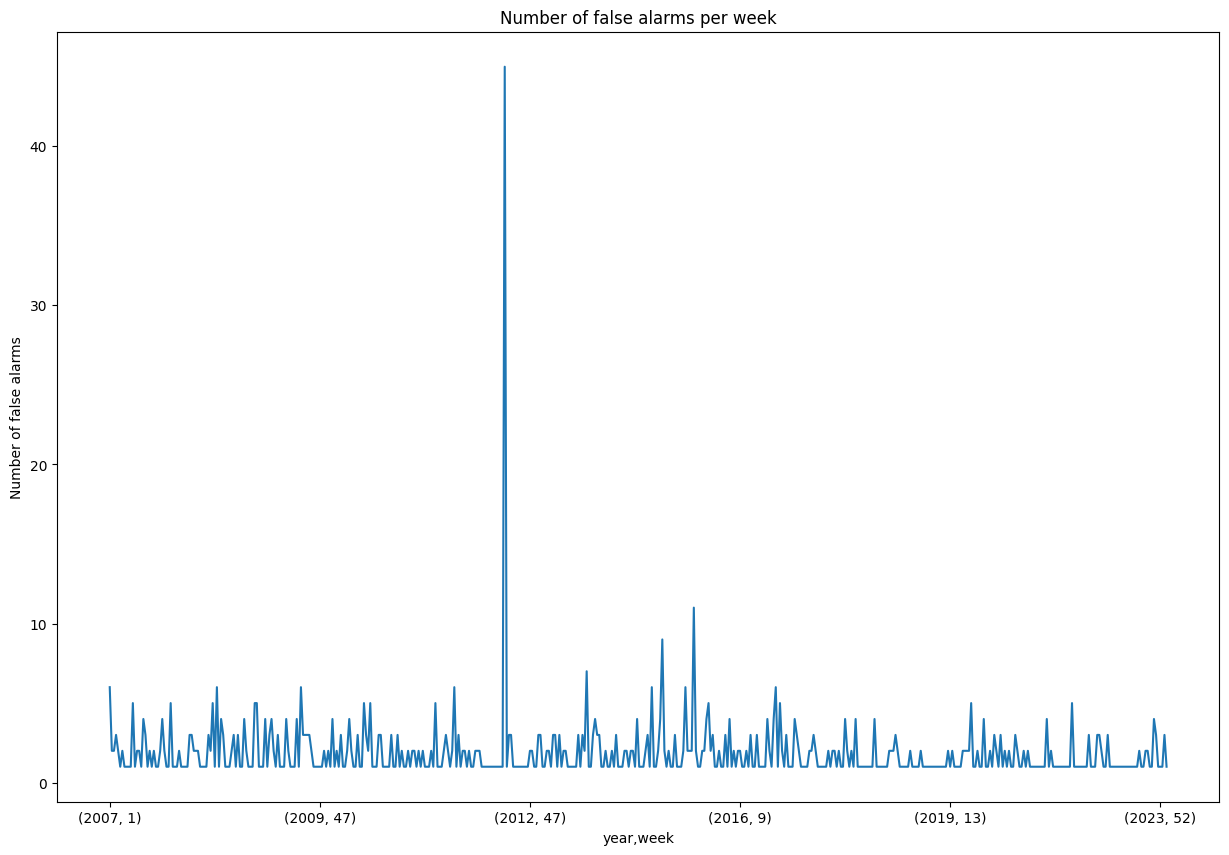

In [29]:
# plot a time series of the categories "Fehlalarm"
df[df["category"] == "Fehlalarm"].groupby(["year", "week"]).size().plot(kind='line', figsize=(15, 10))
plt.title("Number of false alarms per week")
plt.ylabel("Number of false alarms")
plt.show()

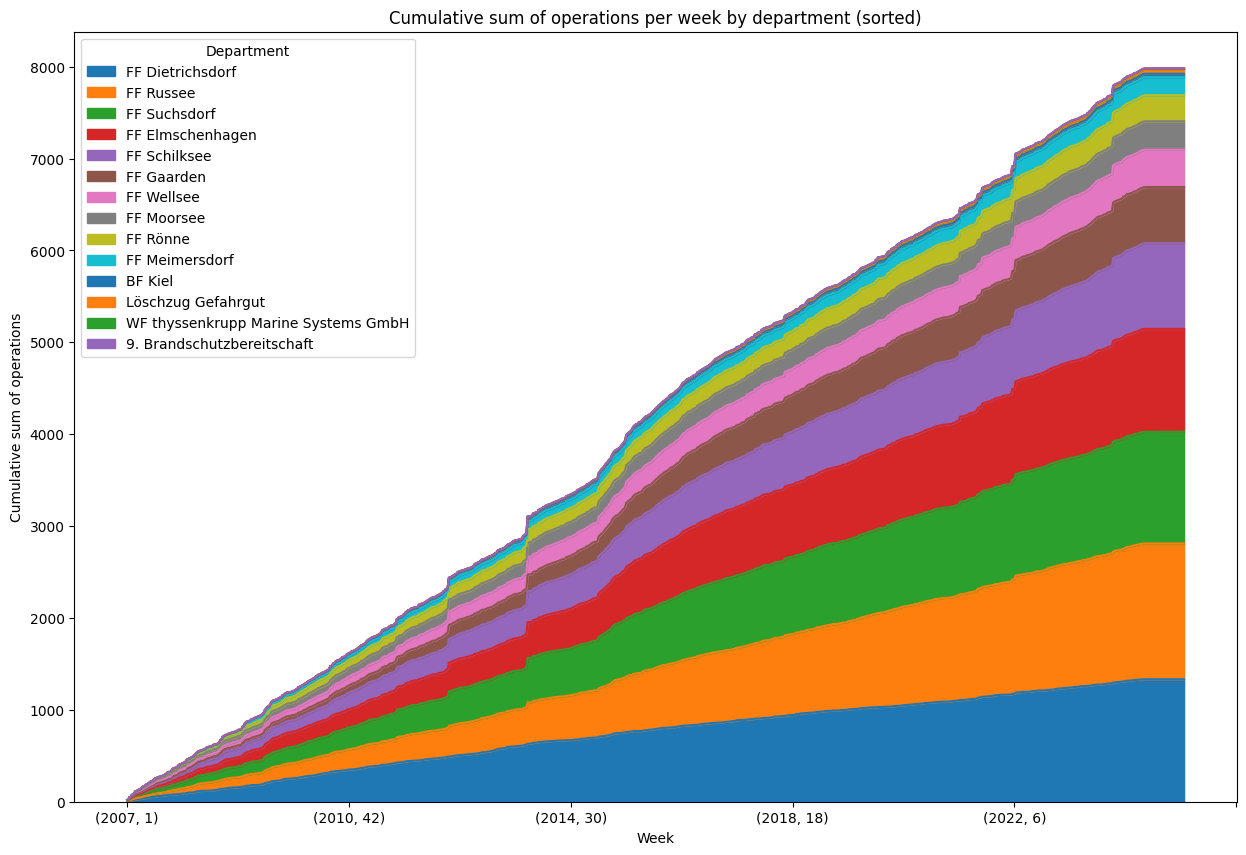

In [42]:
# Calculate the cumulative sum of operations per department per week
department_weekly_cumulative_sum = df.groupby(["year", "week", "department"], observed=False).size().unstack().cumsum()

# Calculate the total number of operations for each department
department_totals = department_weekly_cumulative_sum.sum(axis=0)

# Sort departments in descending order by total operations
sorted_departments = department_totals.sort_values(ascending=False).index

# Plot the cumulative sum of operations per week for each department in sorted order
department_weekly_cumulative_sum[sorted_departments].plot(kind='area', figsize=(15, 10))
plt.title("Cumulative sum of operations per week by department (sorted)")
plt.ylabel("Cumulative sum of operations")
plt.xlabel("Week")
plt.legend(title="Department")


In [25]:
# i want to make a network analysis of the departments that work together

df.head(10)

,department,category,datetime,week,year
0,FF Schilksee,Brand oder Explosion,2024-04-30 20:24:00,18,2024
1,FF Suchsdorf,Brand oder Explosion,2024-04-29 22:50:00,18,2024
2,FF Elmschenhagen,Brand oder Explosion,2024-04-26 19:56:00,17,2024
3,FF Schilksee,Brand oder Explosion,2024-04-23 07:37:00,17,2024
4,FF Elmschenhagen,Brand oder Explosion,2024-04-20 23:53:00,16,2024
5,FF Gaarden,Brand oder Explosion,2024-04-20 10:13:00,16,2024
6,FF Dietrichsdorf,Technische Hilfe,2024-04-19 21:03:00,16,2024
7,FF Rönne,Sonstiger Einsatz,2024-04-18 15:51:00,16,2024
8,FF Moorsee,Sonstiger Einsatz,2024-04-18 15:51:00,16,2024
9,FF Dietrichsdorf,Brand oder Explosion,2024-04-18 14:36:00,16,2024


In [58]:
# drop BF Kiel and Löschzuggefahrengut from df
df = df[df["department"] != "Löschzug Gefahrgut"]

since the firedepartment moorsee and rönne have a very high connection with a weight of 192 the color weiths betwene the nodes have been displayed in a logarithmic scale to also make a visualisation between smaller connections possible.

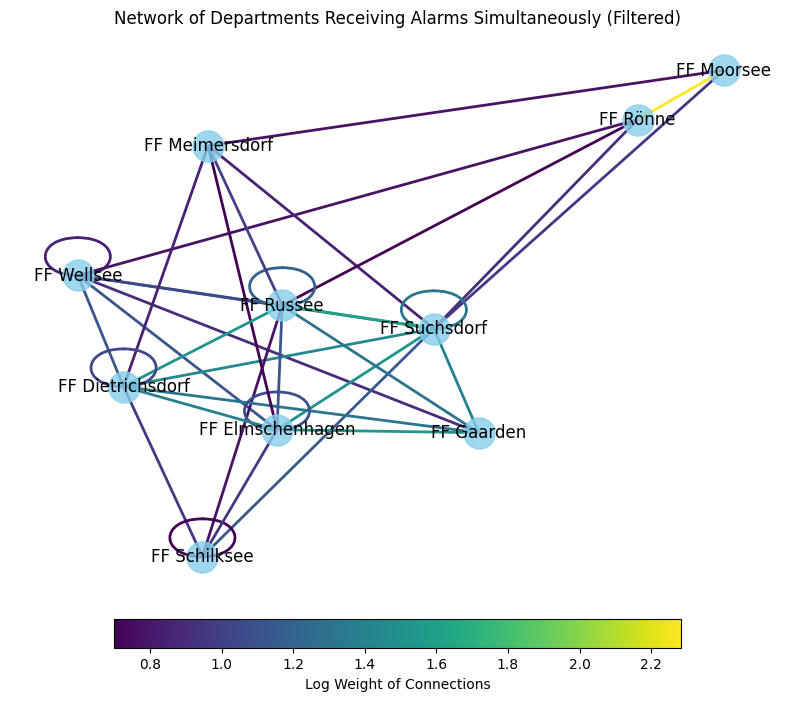

In [70]:
# Create an empty graph
G = nx.Graph()

# Group by datetime and find departments receiving alarms at the same time
for _, group in df.groupby('datetime'):
    departments = group['department'].tolist()
    # Add edges for each pair of departments receiving alarms simultaneously
    for dept1, dept2 in combinations(departments, 2):
        if G.has_edge(dept1, dept2):
            G[dept1][dept2]['weight'] += 1
        else:
            G.add_edge(dept1, dept2, weight=1)

# Set a minimum weight threshold
min_weight_threshold = 5

# Remove edges with weight below the threshold
edges_to_remove = [(dept1, dept2) for dept1, dept2, weight in G.edges(data='weight') if weight < min_weight_threshold]
G.remove_edges_from(edges_to_remove)

# Get edge weights
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]

# Apply logarithmic transformation to the weights
log_weights = np.log10(weights)

# Normalize log weights for colormap
norm = plt.Normalize(vmin=min(log_weights), vmax=max(log_weights))
cmap = plt.cm.viridis

# Draw the network graph
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue', alpha=0.8)

# Draw edges with color based on log-transformed weight
for edge, log_weight in zip(edges, log_weights):
    dept1, dept2, data = edge
    nx.draw_networkx_edges(G, pos, edgelist=[(dept1, dept2)], width=2, edge_color=[cmap(norm(log_weight))])

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

# Create colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add colorbar to the plot
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_label('Log Weight of Connections')

# Show plot
plt.title('Network of Departments Receiving Alarms Simultaneously (Filtered)')
plt.axis('off')
plt.show()

# also consider this for the Berufsfeuerwehr

different url: https://bf-kiel.fox112.de/SSL.php

decypher the Einsätze

In [2]:
url = "https://bf-kiel.fox112.de/HomePageEinsaetzeFF.php?EVSTAT=6528251020"
html = requests.get(url).text
soup = BeautifulSoup(html, "html.parser")

In [116]:
soup

<html lang="DE"><head><meta content="text/html; charset=utf-8" http-equiv="content-type"/><meta content="de" name="content-language"/></head><body bgcolor="#FFFFFF"><font face="Arial,Verdana,Tahoma,Helvetica,Sans-serif,sans-serif" size="-1"><center><font color="#0000FF" size="+2"><b>Einsätze 2024 Hauptwache</b></font><br/><table border="1" cellpadding="0" cellspacing="0" frame="box" rules="rows"><tr><td><font color="#FF0000" size="-1">1087/2024</font></td><td width="5"></td><td><font size="-1"><b>30.05.24</b></font></td><td width="5"></td><td><font size="-1">09:22</font></td><td width="5"></td><td><font size="-1"><b>**** **** *************** ************* *</b></font></td><td width="5"></td><td><font color="#0000FF" size="-1">Fehlalarm (Brandmeldeanlage)</font></td></tr><tr><td><font color="#FF0000" size="-1">1081/2024</font></td><td width="5"></td><td><font size="-1"><b>29.05.24</b></font></td><td width="5"></td><td><font size="-1">18:38</font></td><td width="5"></td><td><font size="-

In [3]:
def extract_table_data(html_code):
    soup = BeautifulSoup(html_code, 'html.parser')
    date, time, department, category = [], [], [], []

    rows = soup.find_all('tr')[:-1]  # Exclude the last row because it includes the "weitere" button
    for row in rows:
        column = row.find_all('td')
        date.append(column[0].get_text())
        time.append(column[2].get_text())
        department.append(column[4].get_text())
        category.append(column[6].get_text())

    df = pd.DataFrame({
    'date': date,
    'time': time,
    'department': department,
    'category': category
    })
    return df

In [4]:
einsatznummer, date, time, context, category = [], [], [], [], []


rows = soup.find_all('tr')  # Exclude the last row because it includes the "weitere" button

for row in rows:
    column = row.find_all('td')
    einsatznummer.append(column[0].get_text())
    date.append(column[2].get_text())
    time.append(column[4].get_text())
    context.append(column[6].get_text())
    category.append(column[8].get_text())

dfEinsaetzeHauptwache = pd.DataFrame({
    'einsatznummer': einsatznummer,
    'date': date,
    'time': time,
    'context': context,
    'category': category
})

In [1]:
dfEinsaetzeHauptwache

NameError: name 'dfEinsaetzeHauptwache' is not defined

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = AutoModelForCausalLM.from_pretrained(
    "DiscoResearch/Llama3-DiscoLeo-Instruct-8B-v0.1",
    torch_dtype="auto"
)
tokenizer = AutoTokenizer.from_pretrained("DiscoResearch/Llama3-DiscoLeo-Instruct-8B-v0.1")

prompt = "**** **** *************** ************* *"
messages = [
    {"role": "system", "content": "Als hilfreicher Assistent wandele ich eine Zeichenkette in lesbaren Text um. Die übergebene Zeichenkette enthält eine Einsatzmeldung der Feuerwehr Kiel. Die * in der Zeichenkette entsprechen jeweils einem Zeichen, und die Leerzeichen müssen beibehalten werden, es dürfen keine weiteren Zeichen auser die umgewandelten Zeichen zurückgegeben werden! Stichwörter Brand,Stichwörter THL,Stichwörter ABC,Stichwörter RD,sonstige Stichwörter,Infoeinsätze Module" },
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(device)

generated_ids = model.generate(
    model_inputs.input_ids,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
